In [ ]:
from dotenv import load_dotenv
from typing import Annotated, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field
from typing_extensions import TypedDict



load_dotenv()

llm = ChatGoogleGenerativeAI(model = "gemini-1.5-flash-latest")

class MessageClassifier(BaseModel):
    message_type: Literal["emotional", "logical"] = Field(
        ...,
        description="Classify whether the message is emotional (therapist) or logical"
    )

class State(TypedDict):
    messages: Annotated[list, add_messages]
    message_type: str | None 

def classify_message(state: State):
    last_message = state["messages"][-1]
    classifier_llm = llm.with_structured_output(MessageClassifier)
    
    result = classifier_llm.invoke([
        {
            "role":"system",
            "content": """Classify the user message as either:
                - 'emotional': if it asks for emotional support, therapy, deals with feelings, or personal problems
                - 'logical': if it asks for facts, information, logical analysis, or practical solutions
            """
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ])

    return {"message_type": result.message_type}


def router(state: State):
    message_type = state.get("message_type", "logical")

    if message_type == "emotional":
        return {"next":"therapist"}
    
    return {"next":"logical"}



def therapist_agent(state: State):
    last_message = state["messages"][-1]

    messages = [
        {
            "role": "system",
            "content": """You are a compassionate therapist. Focus on the emotional aspects of the user's message.
                        Show empathy, validate their feelings, and help them process their emotions.
                        Ask thoughtful questions to help them explore their feelings more deeply.
                        Avoid giving logical solutions unless explicitly asked."""
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ]

    reply = llm.invoke(messages)

    return {"messages": [{"role":"assistant", "content": reply.content}]}


def logical_agent(state: State):
    last_message = state["messages"][-1]

    messages = [
        {
            "role": "system",
            "content": """You are a purely logical assistant. Focus only on facts and information.
            Provide clear, concise answers based on logic and evidence.
            Do not address emotions or provide emotional support.
            Be direct and straightforward in your responses."""
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ]

    reply = llm.invoke(messages)

    return {"messages": [{"role":"assistant", "content": reply.content}]}

graph_builder = StateGraph(State)

graph_builder.add_node("classifier", classify_message)
graph_builder.add_node("router", router)
graph_builder.add_node("therapist", therapist_agent)
graph_builder.add_node("logical", logical_agent)

graph_builder.add_edge(START,"classifier")
graph_builder.add_edge("classifier", "router")
graph_builder.add_conditional_edges(
    "router",
    lambda state: state.get("next"),
    {"therapist": "therapist", "logical": "logical"}
)
graph_builder.add_edge("therapist", END)
graph_builder.add_edge("logical", END)
 
graph = graph_builder.compile()

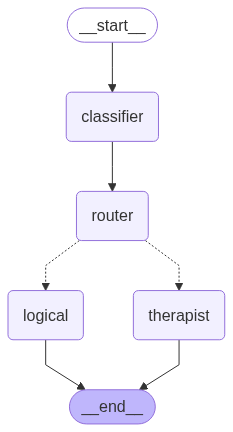

In [ ]:
from IPython.display import Image, display

try:
  # This generates the graph as a PNG and displays it in the notebook output
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(f"⚠️ Warning: Could not generate graph visualization. Error: {e}")